# Análisis inferencial

Este notebook busca crear un análisis inferencial de los datos explorados en la etapa 2. Se busca responde a las siguientes preguntas mediante a la definición de intervalos de confianza y pruebas de hipótesis:

- ¿Qué relación existe entre el nivel educativo y el hábito de lectura de libros en México?
- ¿Cómo influye la disponibilidad de libros en el hogar durante la infancia en los hábitos de lectura en la adultez?

## Definición de valores iniciales

Para el análisis inferencial debemos definir las hipótesis nula y alternativa, así como los valores iniciales que nos permitan realizar las pruebas de hipótesis y calcular los intervalos de confianza.

### Pregunta 1

- **Hipótesis nula (H0)**: Las proporciones de personas que leen son iguales en los distintos niveles educativos.
- **Hipótesis alternativa (H1)**: Al menos una proporción es diferente entre los niveles educativos.

Las proporciones de lectura en los distintos niveles educativos son:
- P_bajo: 0, 1, 2, 3
- P_medio: 4, 5, 6
- P_alto: 7, 8, 9

Las variables que se utilizarán para el análisis son:
- `nivel`: Nivel educativo (1 a 9)
- `p3_1`: Se leyeron libros en los últimos 12 meses
- `p4`: Número de libros leídos en los últimos 12 meses

## Pregunta 2

- **Hipótesis nula (H0)**: Las proporciones de lectura en adultez son iguales entre los niveles de disponibilidad de libros en la infancia.
- **Hipótesis alternativa (H1)**: Al menos una proporción es diferente entre los niveles de disponibilidad de libros en la infancia.

Las proporciones de lectura en los distintos niveles de disponibilidad de libros en la infancia son:
- P_bajo: 0, 1
- P_medio: 2, 3
- P_alto: 4, 5, 6

Las variables que se utilizarán para el análisis son:
- `p34_4`: Disponibilidad de libros en la infancia
- `p34_4_1`: Cantidad de libros de la variante anterior
- `p3_1`: Se leyeron libros en los últimos 12 meses

In [88]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import shapiro

In [89]:
csv_path = "../data/processed/clean_db.csv"
df = pd.read_csv(csv_path, encoding="latin-1", low_memory=False)
df.columns = [c.strip().lower() for c in df.columns]

In [90]:
df = df[(df["p3_1"] != 0)].copy()
df["lector"] = (df["p3_1"] == 1).astype(int)


def map_edu(n):
    if n <= 4:  return "Básico"
    if n <= 6:  return "Medio"
    return "Superior"

df["edu3"] = df["nivel"].map(map_edu)

def map_inf(v):
    if v in [0, 1, 2]: return "Bajo"
    if v in [3, 4]:    return "Medio"
    if v in [5, 6]:    return "Alto"
    return np.nan

df["infancia_grupo"] = df["p34_4_1"].map(map_inf)

In [91]:
alpha = 0.05

def ci_prop(x, n, alpha=0.05):
    z = norm.ppf(1 - alpha/2)
    p = x / n
    se = math.sqrt(p*(1-p)/n)
    return p, p - z*se, p + z*se

def ci_diff_prop(x1, n1, x2, n2, alpha=0.05):
    z = norm.ppf(1 - alpha/2)
    p1, p2 = x1/n1, x2/n2
    se = math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    d = p1 - p2
    return d, d - z*se, d + z*se

def nota(lo, hi):
    return "diferencia clara" if (lo > 0 or hi < 0) else "no concluyente"

In [92]:

def shapiro_conclusion(dataframe, cols, alpha=0.05):
    for col in cols:
        x = dataframe[col].dropna()
        if len(x) < 3:
            print(f"{col}: muestra < 3 → sin prueba")
            continue
        p = shapiro(x)[1]
        msg = "NO se rechaza normalidad" if p > alpha else "Se rechaza normalidad"
        print(f"{col}: {msg}")

shapiro_conclusion(df, ["p4", "p34_4_1"])


p4: Se rechaza normalidad
p34_4_1: Se rechaza normalidad


In [93]:
print("P1. Nivel educativo y hábito de lectura\n")

n = len(df)
x = int(df["lector"].sum())
p, lo, hi = ci_prop(x, n, alpha)
print(f"En total leen {x} de {n} personas, aproximadamente {p:.1%}.")
print(f"Con 95% de confianza, la proporción real está entre {lo:.1%} y {hi:.1%}.\n")

conteos_edu = {}
print("Por nivel educativo:")
for g, sub in df.groupby("edu3"):
    n_g = len(sub)
    x_g = int(sub["lector"].sum())
    p_g, lo_g, hi_g = ci_prop(x_g, n_g, alpha)
    conteos_edu[g] = (x_g, n_g)
    print(f"- {g}: leen {x_g} de {n_g} ({p_g:.1%}). IC 95%: {lo_g:.1%} a {hi_g:.1%}.")

print("\nComparaciones entre grupos:")
x_sup, n_sup = conteos_edu.get("Superior", (0, 0))
x_bas, n_bas = conteos_edu.get("Básico",   (0, 0))
x_med, n_med = conteos_edu.get("Medio",    (0, 0))

if n_sup>0 and n_bas>0:
    d, lo, hi = ci_diff_prop(x_sup, n_sup, x_bas, n_bas, alpha)
    print(f"- Superior vs Básico: diferencia de {d:.1%}. IC 95%: {lo:.1%} a {hi:.1%} "
          f"({nota(lo, hi)}).")
else:
    print("- Superior vs Básico: datos insuficientes.")

if n_sup>0 and n_med>0:
    d, lo, hi = ci_diff_prop(x_sup, n_sup, x_med, n_med, alpha)
    print(f"- Superior vs Medio:  diferencia de {d:.1%}. IC 95%: {lo:.1%} a {hi:.1%} "
          f"({nota(lo, hi)}).")
else:
    print("- Superior vs Medio: datos insuficientes.")


P1. Nivel educativo y hábito de lectura

En total leen 808 de 1966 personas, aproximadamente 41.1%.
Con 95% de confianza, la proporción real está entre 38.9% y 43.3%.

Por nivel educativo:
- Básico: leen 342 de 1186 (28.8%). IC 95%: 26.3% a 31.4%.
- Medio: leen 69 de 155 (44.5%). IC 95%: 36.7% a 52.3%.
- Superior: leen 397 de 625 (63.5%). IC 95%: 59.7% a 67.3%.

Comparaciones entre grupos:
- Superior vs Básico: diferencia de 34.7%. IC 95%: 30.1% a 39.3% (diferencia clara).
- Superior vs Medio:  diferencia de 19.0%. IC 95%: 10.3% a 27.7% (diferencia clara).


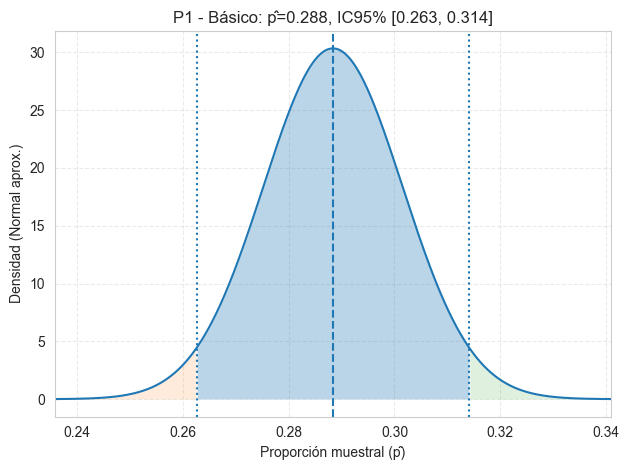

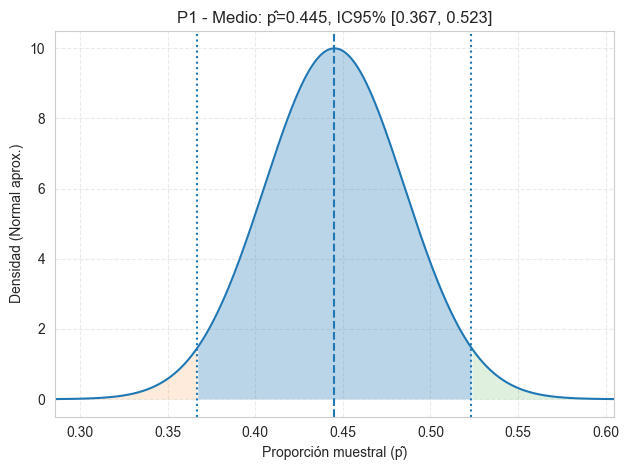

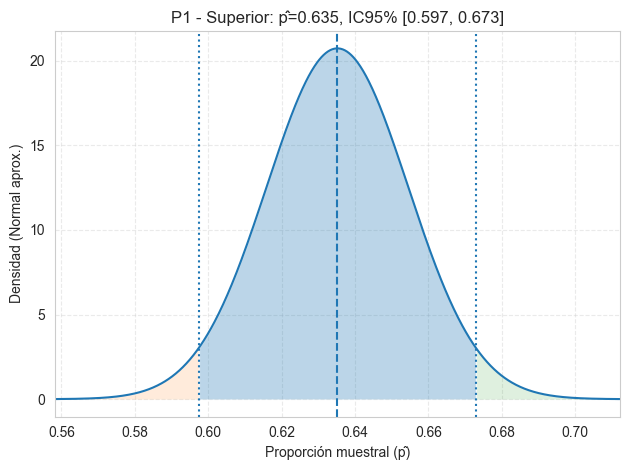

In [94]:
def plot_dist(title, p, se, lo, hi):
    left, right = max(0.0, p-4*se), min(1.0, p+4*se)
    x = np.linspace(left, right, 800)
    y = norm.pdf((x-p)/se)/se
    fig = plt.figure()
    plt.plot(x, y)
    m = (x>=lo)&(x<=hi); plt.fill_between(x[m], 0, y[m], alpha=0.3)
    m = x<lo;            plt.fill_between(x[m], 0, y[m], alpha=0.15)
    m = x>hi;            plt.fill_between(x[m], 0, y[m], alpha=0.15)
    plt.axvline(p, linestyle="--"); plt.axvline(lo, linestyle=":"); plt.axvline(hi, linestyle=":")
    plt.xlim(left, right); plt.xlabel("Proporción muestral (p̂)"); plt.ylabel("Densidad (Normal aprox.)")
    plt.title(title); plt.grid(True, linestyle="--", alpha=0.4); fig.tight_layout()

for g in ["Básico","Medio","Superior"]:
    sub = df[df["edu3"] == g]
    if len(sub) == 0:
        continue
    n = len(sub); x = int((sub["lector"] == 1).sum())
    p, lo, hi = ci_prop(x, n, alpha)
    se = math.sqrt(p*(1-p)/n)
    plot_dist(f"P1 - {g}: p̂={p:.3f}, IC95% [{lo:.3f}, {hi:.3f}]", p, se, lo, hi)

plt.show()

In [95]:
print("\nP2. Libros en la infancia y hábito de lectura\n")

conteos_inf = {}
for g, sub in df.groupby("infancia_grupo"):
    n_g = len(sub)
    x_g = int(sub["lector"].sum())
    p_g, lo_g, hi_g = ci_prop(x_g, n_g, alpha)
    conteos_inf[g] = (x_g, n_g)
    print(f"- {g}: leen {x_g} de {n_g} ({p_g:.1%}). IC 95%: {lo_g:.1%} a {hi_g:.1%}.")

print("\nComparación clave (Alto vs Bajo):")
x_alt, n_alt = conteos_inf.get("Alto", (0, 0))
x_baj, n_baj = conteos_inf.get("Bajo", (0, 0))
if n_alt>0 and n_baj>0:
    d, lo, hi = ci_diff_prop(x_alt, n_alt, x_baj, n_baj, alpha)
    print(f"- Diferencia de {d:.1%}. IC 95%: {lo:.1%} a {hi:.1%} ({nota(lo, hi)}).")
else:
    print("- Datos insuficientes para comparar.")



P2. Libros en la infancia y hábito de lectura

- Alto: leen 54 de 72 (75.0%). IC 95%: 65.0% a 85.0%.
- Bajo: leen 663 de 1749 (37.9%). IC 95%: 35.6% a 40.2%.
- Medio: leen 91 de 145 (62.8%). IC 95%: 54.9% a 70.6%.

Comparación clave (Alto vs Bajo):
- Diferencia de 37.1%. IC 95%: 26.8% a 47.3% (diferencia clara).


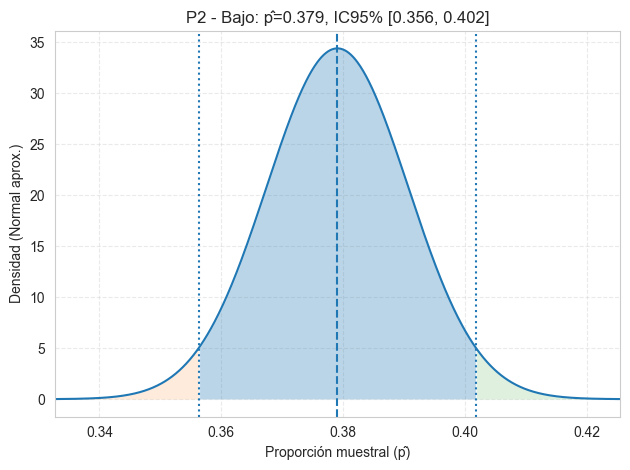

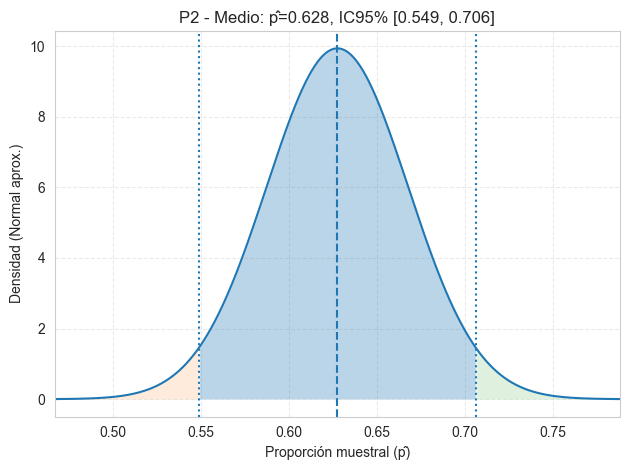

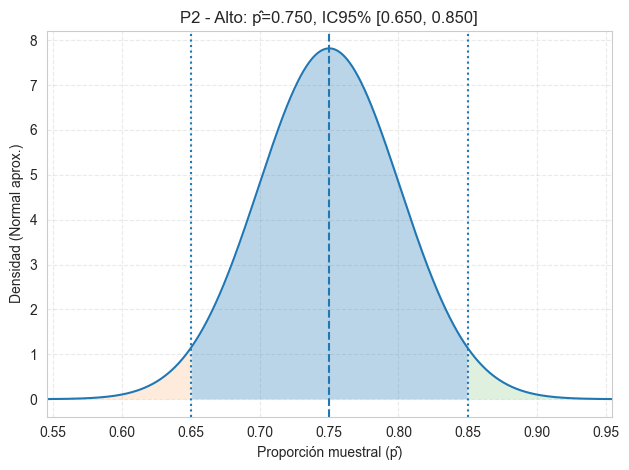

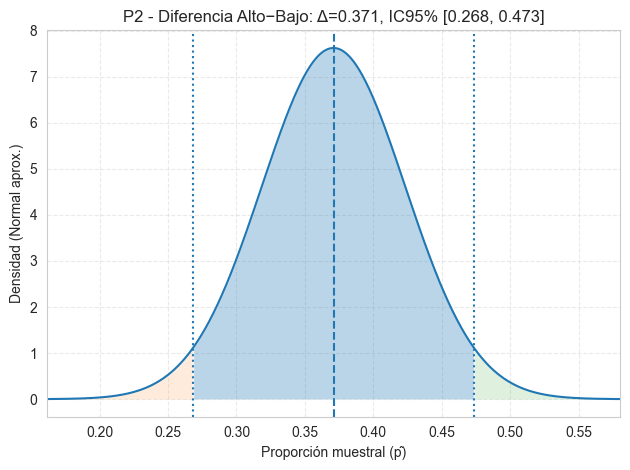

In [96]:
for g in ["Bajo","Medio","Alto"]:
    sub = df[df["infancia_grupo"] == g]
    if len(sub) == 0:
        continue
    n = len(sub); x = int((sub["lector"] == 1).sum())
    p, lo, hi = ci_prop(x, n, alpha)
    se = math.sqrt(p*(1-p)/n)
    plot_dist(f"P2 - {g}: p̂={p:.3f}, IC95% [{lo:.3f}, {hi:.3f}]", p, se, lo, hi)

subA = df[df["infancia_grupo"] == "Alto"]
subB = df[df["infancia_grupo"] == "Bajo"]
if len(subA) > 0 and len(subB) > 0:
    n1, x1 = len(subA), int((subA["lector"] == 1).sum())
    n2, x2 = len(subB), int((subB["lector"] == 1).sum())
    p1, _, _ = ci_prop(x1, n1, alpha)
    p2, _, _ = ci_prop(x2, n2, alpha)
    se1 = math.sqrt(p1*(1-p1)/n1)
    se2 = math.sqrt(p2*(1-p2)/n2)
    d = p1 - p2
    se_d = math.sqrt(se1**2 + se2**2)
    z = norm.ppf(1 - alpha/2)
    lo_d, hi_d = d - z*se_d, d + z*se_d
    plot_dist(f"P2 - Diferencia Alto−Bajo: Δ={d:.3f}, IC95% [{lo_d:.3f}, {hi_d:.3f}]", d, se_d, lo_d, hi_d)

plt.show()